# Steinberg-Style Analysis

This notebook will be used to replicate some of the methods and plots from [[Steinberg 2022]] using argo data. To see a list of applicable tasks and other useful notes, see: https://github.com/ocean-transport/argo-intern/issues/10#issuecomment-1574128413 

In [54]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import MLD_funcs as mf

In [73]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
reload(mf)

<module 'MLD_funcs' from '/home.ufs/amf2288/argo-intern/MLD_funcs.py'>

In [53]:
'''
box_z = xr.open_dataset('202206_boxes/lon:(25,45)_lat:(-60,-50)_ds_z.nc')
box_r = xr.open_dataset('202206_boxes/lon:(25,45)_lat:(-60,-50)_ds_rho.nc')
'''

"\nbox_z = xr.open_dataset('202206_boxes/lon:(25,45)_lat:(-60,-50)_ds_z.nc')\nbox_r = xr.open_dataset('202206_boxes/lon:(25,45)_lat:(-60,-50)_ds_rho.nc')\n"

In [25]:
box_z = xr.open_dataset('202206_boxes/lon:(25,30)_lat:(-60,-55)_ds_z.nc')
box_r = xr.open_dataset('202206_boxes/lon:(25,30)_lat:(-60,-55)_ds_rho.nc')

In [26]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_rho = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

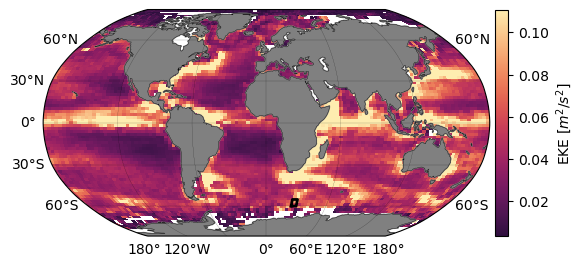

In [27]:
pf.plot_box([[25,30,-60,-55]])

## Figure 3

I'd like to make this plot (or at least parts a/b and e/f) because I think it's visually useful to frame what density surfaces look like in a given region, however I haven't solved the profile identification issue from the methods notebook, so I think it's best to put this plot on hold for now. If the MLD .nc file is more of a pain than it's worth, I can also calculate MLD using threshold values at least.

Ultimately, this is probably a rabbit hole that might not be that important to chase down right now. Move forward with something you know you can do.

In [74]:
box_t = mf.add_times(box_z)
box_t = mf.get_MLD(box_t)

In [75]:
SIG0_01 = box_t.SIG0.where(box_t.month<2).dropna('N_PROF')

In [91]:
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

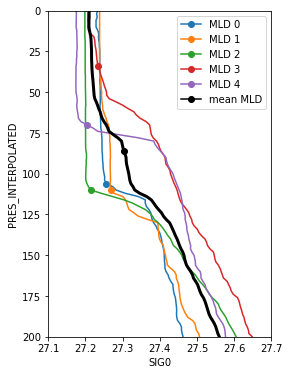

In [119]:
#Make this plot with 12 panels, one for each month
#Then make one plot with 12 lines, one average for each month

plt.figure(figsize=(4,6))
for n in range(0,len(SIG0_01)):
    SIG0_01[n].plot(y='PRES_INTERPOLATED',color=colors[n])
    plt.plot(SIG0_01[n].sel(PRES_INTERPOLATED=SIG0_01[n].MLD).values,SIG0_01[n].MLD,marker='o',label='MLD {}'.format(n),color=colors[n])

SIG0_01.mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k',linewidth='3')
plt.plot(SIG0_01.mean('N_PROF').sel(PRES_INTERPOLATED=SIG0_01.MLD.mean('N_PROF')).values,SIG0_01.MLD.mean('N_PROF'),marker='o',label='mean MLD'.format(n),color='k')
plt.ylim(0,200)
plt.xlim(27.1,27.7)
plt.legend()
plt.gca().invert_yaxis()

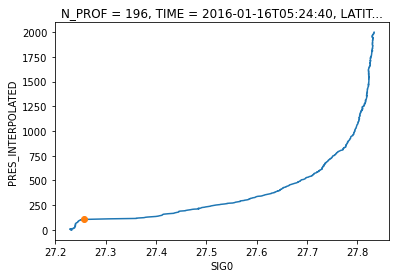

In [98]:
SIG0_01[0].plot(y='PRES_INTERPOLATED')
plt.plot(SIG0_01[0].sel(PRES_INTERPOLATED=106).values,SIG0_01[0].MLD,marker='o')

In [93]:
SIG0_01[0].MLD

<xarray.DataArray 'MLD' ()>
array(106)
Coordinates:
    N_PROF      int64 196
    TIME        datetime64[ns] 2016-01-16T05:24:40
    LATITUDE    float64 -55.39
    LONGITUDE   float64 27.68
    N_PROF_NEW  int64 4
    month       int64 1
    month_frac  float64 1.523
    year        int64 2016
    year_frac   float64 2.016e+03
    MLD         int64 106

In [95]:
SIG0_01[0].isel(PRES_INTERPOLATED=106)

<xarray.DataArray 'SIG0' ()>
array(27.48431236)
Coordinates:
    N_PROF             int64 196
    TIME               datetime64[ns] 2016-01-16T05:24:40
    LATITUDE           float64 -55.39
    LONGITUDE          float64 27.68
    PRES_INTERPOLATED  int64 212
    N_PROF_NEW         int64 4
    month              int64 1
    month_frac         float64 1.523
    year               int64 2016
    year_frac          float64 2.016e+03
    MLD                int64 106
Attributes:
    casted:   1

## Figure 5

This plot shows variance at different locations, filter scales, and seasons and we would additionally need it to displace these metrics across depths. That's a lot of information floating out there. I think it makes sense to only focus on one region and figure out how to show variance at different scales, seasons, and depths at that specific location. Then expand the geography when you're more comfortable

In [28]:
l1 = 100
l2 = 200
l3 = 400

In [29]:
MKE0 = ef.get_EV(box_z,l1,variable='SPICE')
MKE1 = ef.get_MV(box_z,l1,variable='SPICE')
MKE2 = ef.get_MV(box_z,l2,variable='SPICE')
MKE3 = ef.get_MV(box_z,l3,variable='SPICE')

EKE0 = ef.get_EV(box_z,l1,variable='SPICE')
EKE1 = ef.get_EV(box_z,l2,variable='SPICE')
EKE2 = ef.get_EV(box_z,l3,variable='SPICE')
EKE3 = ef.get_MV(box_z,l3,variable='SPICE')

In [30]:
MKE0_v = EKE1
MKE1_v = MKE1 - MKE2
MKE2_v = MKE2 - MKE3
MKE3_v = MKE3

EKE0_v = EKE1
EKE1_v = EKE2 - EKE1
EKE2_v = EKE3 - EKE2
EKE3_v = MKE3

Need a function that adds a month coordinate to xarray, it's annoying to have to type ".TIME.dt.month" every time. 

Now that I've made the one below, I'm considering I don't want an integer value of 0-12 because I need a smooth curve that runs from January to December. Instead, I need something that is fractional month (to progressively move along the x axis) and this should reorder the DataArray so the sequence is strictly increasing.

In [31]:
def add_month(ds, variable='TIME'):
    
    ds['frac_day'] = ds.TIME.dt.day + (ds.TIME.dt.hour / 24) + (ds.TIME.dt.minute / (24*60)) + (ds.TIME.dt.minute / (24*60*60))
    ds['frac_month'] = ds.TIME.dt.month + (ds.frac_day / ds.TIME.dt.days_in_month)
    
    month_li = []
    for i in range(0,len(ds.N_PROF)):
        month_li.append(ds.isel(N_PROF=i).TIME.dt.month)
    
    return ds.assign_coords(month=('N_PROF',month_li))

In [32]:
MKE0_v = add_month(MKE0_v)
MKE1_v = add_month(MKE1_v)
MKE2_v = add_month(MKE2_v)
MKE3_v = add_month(MKE3_v)

EKE0_v = add_month(EKE0_v)
EKE1_v = add_month(EKE1_v)
EKE2_v = add_month(EKE2_v)
EKE3_v = add_month(EKE3_v)

MKE0_vm = MKE0_v.sortby('frac_month')
MKE1_vm = MKE1_v.sortby('frac_month')
MKE2_vm = MKE2_v.sortby('frac_month')
MKE3_vm = MKE3_v.sortby('frac_month')

EKE0_vm = EKE0_v.sortby('frac_month')
EKE1_vm = EKE1_v.sortby('frac_month')
EKE2_vm = EKE2_v.sortby('frac_month')
EKE3_vm = EKE3_v.sortby('frac_month')

In [33]:
def add_year(ds, variable='TIME'):
    
    ds['frac_day'] = ds.TIME.dt.day + (ds.TIME.dt.hour / 24) + (ds.TIME.dt.minute / (24*60)) + (ds.TIME.dt.minute / (24*60*60))
    ds['frac_month'] = ds.TIME.dt.month + (ds.frac_day / ds.TIME.dt.days_in_month)
    ds['frac_year'] = ds.TIME.dt.year + (ds.frac_month / 12)
    
    year_li = []
    for i in range(0,len(ds.N_PROF)):
        year_li.append(ds.isel(N_PROF=i).TIME.dt.year)
    
    return ds.assign_coords(year=('N_PROF',year_li))

In [34]:
MKE0_v = add_year(MKE0_v)
MKE1_v = add_year(MKE1_v)
MKE2_v = add_year(MKE2_v)
MKE3_v = add_year(MKE3_v)

EKE0_v = add_year(EKE0_v)
EKE1_v = add_year(EKE1_v)
EKE2_v = add_year(EKE2_v)
EKE3_v = add_year(EKE3_v)

MKE0_vy = MKE0_v.sortby('frac_year')
MKE1_vy = MKE1_v.sortby('frac_year')
MKE2_vy = MKE2_v.sortby('frac_year')
MKE3_vy = MKE3_v.sortby('frac_year')

EKE0_vy = EKE0_v.sortby('frac_year')
EKE1_vy = EKE1_v.sortby('frac_year')
EKE2_vy = EKE2_v.sortby('frac_year')
EKE3_vy = EKE3_v.sortby('frac_year')

In [35]:
month_labels=['J','F','M','A','M','J','J','A','S','O','N','D']

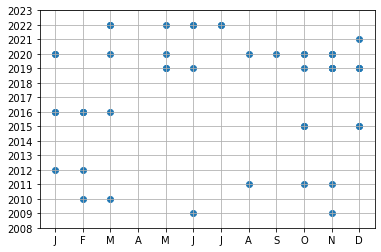

In [36]:
plt.scatter(MKE0_v.month, MKE0_v.year)
plt.xticks(ticks=range(1,13),labels=month_labels)
plt.yticks(ticks=range(2008,2024),labels=range(2008,2024))
plt.grid()

Text(0.5, 1.0, 'EKE System, annual')

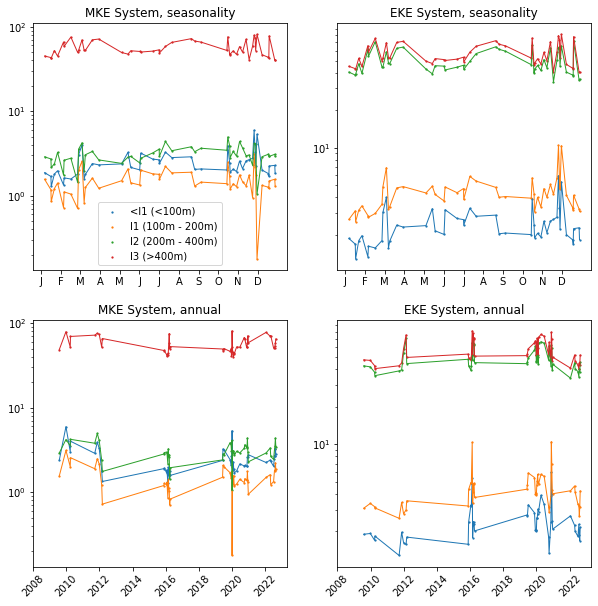

In [47]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.scatter(MKE0_vm.frac_month, MKE0_vm.sum('PRES_INTERPOLATED'),label='<l1 (<{}m)'.format(l1),s=1.5)
plt.plot(MKE0_vm.frac_month, MKE0_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(MKE1_vm.frac_month, MKE1_vm.sum('PRES_INTERPOLATED'),label='l1 ({}m - {}m)'.format(l1,l2),s=1.5)
plt.plot(MKE1_vm.frac_month, MKE1_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(MKE2_vm.frac_month, MKE2_vm.sum('PRES_INTERPOLATED'),label='l2 ({}m - {}m)'.format(l2,l3),s=1.5)
plt.plot(MKE2_vm.frac_month, MKE2_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(MKE3_vm.frac_month, MKE3_vm.sum('PRES_INTERPOLATED'),label='l3 (>{}m)'.format(l3),s=1.5)
plt.plot(MKE3_vm.frac_month, MKE3_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.xticks(ticks=range(1,13),labels=month_labels)
plt.legend()
plt.yscale('log')
plt.title('MKE System, seasonality')

plt.subplot(2,2,2)
plt.scatter(EKE0_vm.frac_month, EKE0_vm.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE0_vm.frac_month, EKE0_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE1_vm.frac_month, EKE1_vm.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE1_vm.frac_month, EKE1_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE2_vm.frac_month, EKE2_vm.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE2_vm.frac_month, EKE2_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE3_vm.frac_month, EKE3_vm.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE3_vm.frac_month, EKE3_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.xticks(ticks=range(1,13),labels=month_labels)
plt.yscale('log')
plt.title('EKE System, seasonality')
          
plt.subplot(2,2,3)
plt.scatter(MKE0_vy.frac_year, MKE0_vy.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(MKE0_vy.frac_year, MKE0_vy.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(MKE1_vy.frac_year, MKE1_vy.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(MKE1_vy.frac_year, MKE1_vy.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(MKE2_vy.frac_year, MKE2_vy.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(MKE2_vy.frac_year, MKE2_vy.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(MKE3_vy.frac_year, MKE3_vy.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(MKE3_vy.frac_year, MKE3_vy.sum('PRES_INTERPOLATED'),linewidth=1)
plt.xticks(ticks=range(2008,2024,2),labels=range(2008,2024,2),rotation=45)
plt.yscale('log')
plt.title('MKE System, annual')

plt.subplot(2,2,4)
plt.scatter(EKE0_vy.frac_year, EKE0_v.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE0_vy.frac_year, EKE0_v.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE1_vy.frac_year, EKE1_v.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE1_vy.frac_year, EKE1_v.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE2_vy.frac_year, EKE2_v.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE2_vy.frac_year, EKE2_v.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE3_vy.frac_year, EKE3_v.sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE3_vy.frac_year, EKE3_v.sum('PRES_INTERPOLATED'),linewidth=1)
plt.xticks(ticks=range(2008,2024,2),labels=range(2008,2024,2),rotation=45)
plt.yscale('log')
plt.title('EKE System, annual')

In [50]:
d1 = 150
d2 = 500
d3 = 1000

Text(0.5, 1.0, '1000m-2000m')

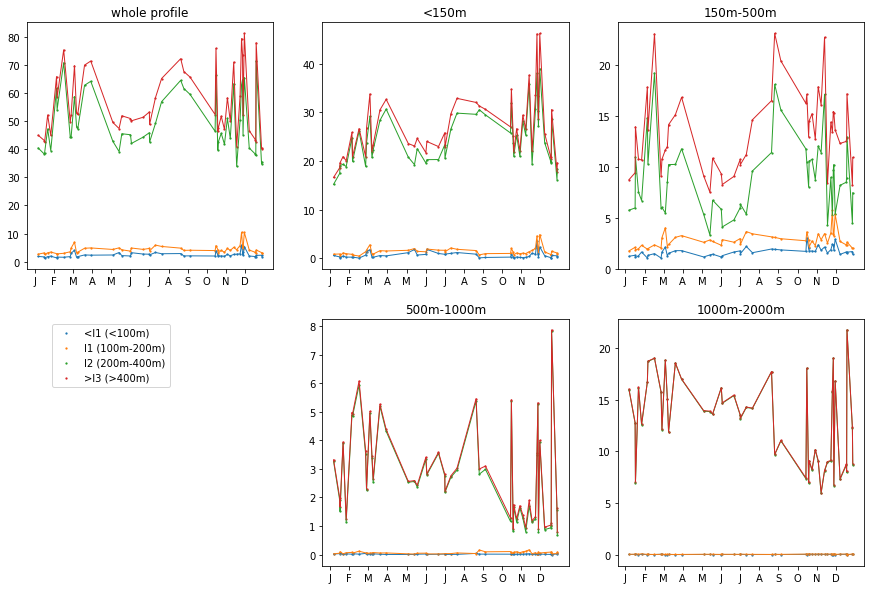

In [52]:
plt.figure(figsize=(15,10))


plt.subplot(2,3,1)
plt.scatter(EKE0_vm.frac_month, EKE0_vm.sum('PRES_INTERPOLATED'),label='<l1 (<{}m)'.format(l1),s=1.5)
plt.plot(EKE0_vm.frac_month, EKE0_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE1_vm.frac_month, EKE1_vm.sum('PRES_INTERPOLATED'),label='l1 ({}m-{}m)'.format(l1,l2),s=1.5)
plt.plot(EKE1_vm.frac_month, EKE1_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE2_vm.frac_month, EKE2_vm.sum('PRES_INTERPOLATED'),label='l2 ({}m-{}m)'.format(l2,l3),s=1.5)
plt.plot(EKE2_vm.frac_month, EKE2_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE3_vm.frac_month, EKE3_vm.sum('PRES_INTERPOLATED'),label='>l3 (>{}m)'.format(l3),s=1.5)
plt.plot(EKE3_vm.frac_month, EKE3_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.xticks(ticks=range(1,13),labels=month_labels)
plt.legend(bbox_to_anchor=(0.6, -0.2))
plt.title('whole profile')

plt.subplot(2,3,2)
plt.scatter(EKE0_vm.frac_month, EKE0_vm.where(EKE0.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE0_vm.frac_month, EKE0_vm.where(EKE0.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE1_vm.frac_month, EKE1_vm.where(EKE0.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE1_vm.frac_month, EKE1_vm.where(EKE0.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE2_vm.frac_month, EKE2_vm.where(EKE0.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE2_vm.frac_month, EKE2_vm.where(EKE0.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE3_vm.frac_month, EKE3_vm.where(EKE0.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE3_vm.frac_month, EKE3_vm.where(EKE0.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED'),linewidth=1)
plt.xticks(ticks=range(1,13),labels=month_labels)
plt.title('<{}m'.format(d1))

plt.subplot(2,3,3)
plt.scatter(EKE0_vm.frac_month, EKE0_vm.where(EKE0.PRES_INTERPOLATED<d2).where(EKE0.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE0_vm.frac_month, EKE0_vm.where(EKE0.PRES_INTERPOLATED<d2).where(EKE0.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE1_vm.frac_month, EKE1_vm.where(EKE0.PRES_INTERPOLATED<d2).where(EKE0.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE1_vm.frac_month, EKE1_vm.where(EKE0.PRES_INTERPOLATED<d2).where(EKE0.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE2_vm.frac_month, EKE2_vm.where(EKE0.PRES_INTERPOLATED<d2).where(EKE0.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE2_vm.frac_month, EKE2_vm.where(EKE0.PRES_INTERPOLATED<d2).where(EKE0.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE3_vm.frac_month, EKE3_vm.where(EKE0.PRES_INTERPOLATED<d2).where(EKE0.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE3_vm.frac_month, EKE3_vm.where(EKE0.PRES_INTERPOLATED<d2).where(EKE0.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED'),linewidth=1)
plt.xticks(ticks=range(1,13),labels=month_labels)
plt.title('{}m-{}m'.format(d1,d2))

plt.subplot(2,3,5)
plt.scatter(EKE0_vm.frac_month, EKE0_vm.where(EKE0.PRES_INTERPOLATED<d3).where(EKE0.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE0_vm.frac_month, EKE0_vm.where(EKE0.PRES_INTERPOLATED<d3).where(EKE0.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE1_vm.frac_month, EKE1_vm.where(EKE0.PRES_INTERPOLATED<d3).where(EKE0.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE1_vm.frac_month, EKE1_vm.where(EKE0.PRES_INTERPOLATED<d3).where(EKE0.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE2_vm.frac_month, EKE2_vm.where(EKE0.PRES_INTERPOLATED<d3).where(EKE0.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE2_vm.frac_month, EKE2_vm.where(EKE0.PRES_INTERPOLATED<d3).where(EKE0.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE3_vm.frac_month, EKE3_vm.where(EKE0.PRES_INTERPOLATED<d3).where(EKE0.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE3_vm.frac_month, EKE3_vm.where(EKE0.PRES_INTERPOLATED<d3).where(EKE0.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED'),linewidth=1)
plt.xticks(ticks=range(1,13),labels=month_labels)
plt.title('{}m-{}m'.format(d2,d3))

plt.subplot(2,3,6)
plt.scatter(EKE0_vm.frac_month, EKE0_vm.where(EKE0.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE0_vm.frac_month, EKE0_vm.where(EKE0.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE1_vm.frac_month, EKE1_vm.where(EKE0.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE1_vm.frac_month, EKE1_vm.where(EKE0.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE2_vm.frac_month, EKE2_vm.where(EKE0.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE2_vm.frac_month, EKE2_vm.where(EKE0.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE3_vm.frac_month, EKE3_vm.where(EKE0.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED'),s=1.5)
plt.plot(EKE3_vm.frac_month, EKE3_vm.where(EKE0.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED'),linewidth=1)
plt.xticks(ticks=range(1,13),labels=month_labels)
plt.title('{}m-2000m'.format(d3))

There is a lot going on in this plot, with four bins for four depth sections of a profile, all separated by season. I think part of what makes it difficult to synthesize and intepret is the very large oscillations that seem to obscure larger trends. 

Text(0.5, 1.0, 'whole profile')

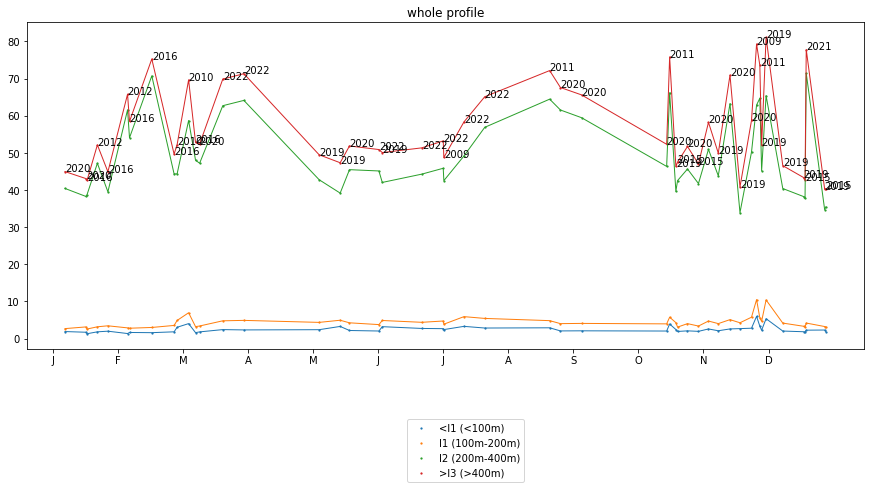

In [39]:
plt.figure(figsize=(15,6))

plt.scatter(EKE0_vm.frac_month, EKE0_vm.sum('PRES_INTERPOLATED'),label='<l1 (<{}m)'.format(l1),s=1.5)
plt.plot(EKE0_vm.frac_month, EKE0_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE1_vm.frac_month, EKE1_vm.sum('PRES_INTERPOLATED'),label='l1 ({}m-{}m)'.format(l1,l2),s=1.5)
plt.plot(EKE1_vm.frac_month, EKE1_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE2_vm.frac_month, EKE2_vm.sum('PRES_INTERPOLATED'),label='l2 ({}m-{}m)'.format(l2,l3),s=1.5)
plt.plot(EKE2_vm.frac_month, EKE2_vm.sum('PRES_INTERPOLATED'),linewidth=1)
plt.scatter(EKE3_vm.frac_month, EKE3_vm.sum('PRES_INTERPOLATED'),label='>l3 (>{}m)'.format(l3),s=1.5)
plt.plot(EKE3_vm.frac_month, EKE3_vm.sum('PRES_INTERPOLATED'),linewidth=1)

for i,num in enumerate(EKE3_vm.TIME.dt.year.values):
    plt.annotate(num, (EKE3_vm.frac_month[i],EKE3_vm.sum('PRES_INTERPOLATED')[i]))
    
plt.xticks(ticks=range(1,13),labels=month_labels)
plt.legend(bbox_to_anchor=(0.6, -0.2))
plt.title('whole profile')